# ЗАДАНИЕ

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

# РЕШЕНИЕ

In [1]:
from scipy.stats import ttest_1samp
import numpy as np
import pandas as pd


from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Проверим есть ли юзера, встречающиеся одновременно в 2-х версиях

In [9]:
v = df.\
    groupby('userid', as_index=False).\
    agg({'version': pd.Series.nunique})
v

,userid,version
0,116,1
1,337,1
2,377,1
3,483,1
4,488,1
...,...,...
90184,9999441,1
90185,9999479,1
90186,9999710,1
90187,9999768,1


Как показала таблица, каждый юзер сщщтнесён строго к определённой группе(версии), что даёт возможность дальше продолжать анализ

In [10]:
alpha = 0.05

st = shapiro(df.sum_gamerounds)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]))

Distribution is not normal



Тесть Шапиро показал, что распределение ненормальное

Так как у нас огромная выборка, то целесообразно использовать тест Колмогорова-Смирнова

In [11]:
print(kstest(df.sum_gamerounds, 'norm'))

KstestResult(statistic=0.8715607041848303, pvalue=0.0, statistic_location=2, statistic_sign=-1)


В данном случае, p-значение равно 0.0, что указывает на то, что нулевая гипотеза может быть отвергнута.

statistic_sign=-1, что означает, что вторая эмпирическая выборка имеет большее удаление от гипотетического распределения, чем первая выборка.

Визуально построим графики для имеющихся данных

In [12]:
control = df.query('version == "gate_30"')

test = df.query('version == "gate_40"')

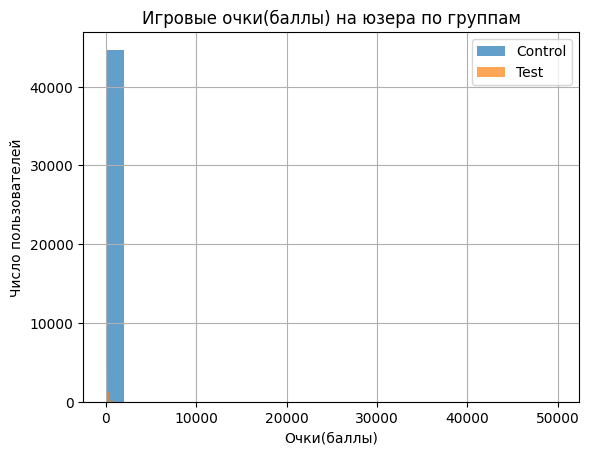

In [27]:
control.sum_gamerounds.hist(bins = 25, alpha =0.7, label='Control')
test.sum_gamerounds.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Игровые очки(баллы) на юзера по группам')
plt.xlabel('Очки(баллы)')
plt.ylabel('Число пользователей')
plt.legend();

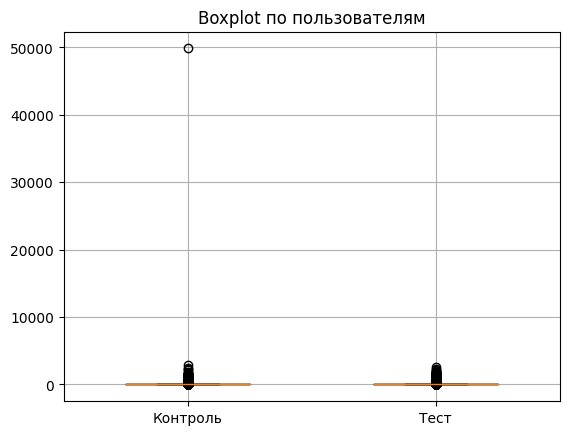

In [14]:
plt.boxplot([control.sum_gamerounds,test.sum_gamerounds],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [22]:
#group = df[['version', 'sum_gamerounds']].groupby(['version'], as_index=False)
#group

In [25]:
grouped_data_sum = group['sum_gamerounds'].sum()
grouped_data_sum

,version,sum_gamerounds
0,gate_30,2344795
1,gate_40,2333530


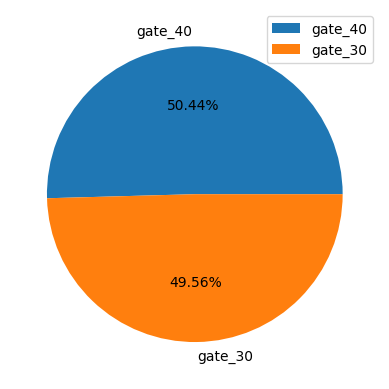

In [26]:
data = df['version'].value_counts()
plt.pie(data.values, labels=data.index, autopct='%1.2f%%')
plt.legend(data.index);

Видно, что между двумя версиями практически нет  большой разницы.

In [29]:
import seaborn as sns

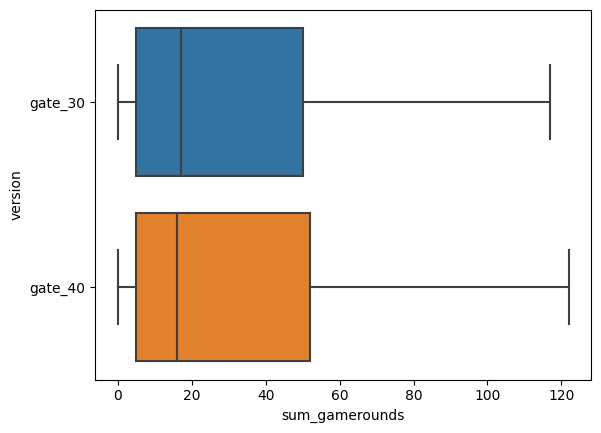

In [32]:
sns.boxplot(x=df['sum_gamerounds'], y=df['version'], showfliers=False);

Видим, что есть небольшая разница. Вторая версия немного превалирует

Расчитаем Т-статистику

In [34]:
import scipy.stats as stats

In [35]:
stats.ttest_ind(control.sum_gamerounds.values, test.sum_gamerounds.values, equal_var = False)

TtestResult(statistic=0.8854374331270672, pvalue=0.37592438409326223, df=58595.481422574)

p-значение составляет 0.37592438409326223, что означает, что у нас нет достаточных доказательств, чтобы отвергнуть нулевую гипотезу (отсутствие различий между выборками).

Принимать во внимание данный факт об отсутствии различий скоротечно не стоит, так как тест Колмогорова-Смирнова(так как выборка больше 5000, что является более правильным подходом)и тест Шапиро Уилка показали обратное  что есть различия между двумя версиями игры

Продолжим анализ, определим мощность теста для более детального умозаключения

In [36]:
C_mean = control.sum_gamerounds.values.mean()

T_mean = test.sum_gamerounds.values.mean()


C_std = control.sum_gamerounds.values.std()

T_std = test.sum_gamerounds.values.std()

In [37]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [38]:
effect_size =float((T_mean-C_mean)/ S)

In [44]:
n = 44700

In [45]:
from statsmodels.stats.power import TTestIndPower

In [47]:
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.14327904497194127

In [ ]:
Мощность теста составляет 14%

Мощность теста указывает на вероятность правильно отклонить нулевую гипотезу, когда она действительно неверна. В нашем случае, мощность теста составляет 14%. Это означает, что вероятность правильно обнаружить эффект или связь между переменными довольно низкая. Если мощность теста слишком низкая, то есть высокая вероятность принять нулевую гипотезу, даже если она неверна. В таком случае, результаты теста могут быть менее надежными и требуют дальнейшего исследования или анализа.

На основе проведённого анализа сделаем общий вывод:

1. Отвергнуть нулевую гипотезу: Учитывая низкое p-значение, мы можем с уверенностью сказать, что ввод новых изменений в игру Cookie Cats (версия gate_40) привел к значимо другому распределению количества пройденных игровых раундов по сравнению с контрольной группой (версия gate_30). Поэтому мы можем отвергнуть нулевую гипотезу о том, что различий между двумя версиями игры нет.

2. Проанализировать результаты более подробно: Взглянув на статистику Колмогорова-Смирнова и ее положение во втором распределении, можно сделать вывод, что версия gate_40 имеет большее удаление от гипотетического распределения. Дальнейший анализ и исследование этого расхождения могут помочь понять, какие конкретные изменения внедрены в версию gate_40, и как они могут повлиять на пользовательское поведение и удовлетворенность игроков.



3. Продолжить мониторинг результатов: В результате AB-тестирования мы получили статистически значимые результаты, но это не означает, что результаты являются окончательными или долгосрочными. Рекомендуется продолжить мониторинг результатов и дальнейшие тестирования, чтобы убедиться в стабильности и долгосрочной эффективности новой версии игры.

4. Обсудить идеи для дальнейшего улучшения: На основе результатов AB-теста, можно провести обсуждение с командой разработки и менеджментом о дальнейших идеях и улучшениях, которые могут быть внедрены в версию gate_40 для оптимизации пользовательского опыта и достижения более высоких показателей в игре. Эти идеи могут быть основаны на анализе данных и обратной связи от активных пользователей игры.